# Notebook 1: Eksploracyjna Analiza Danych (EDA)
## Analiza Sentymentu Recenzji Amazon - Projekt ZUM
Magdalena Sokolowska, PJATK, Informatyka mgr, 2026
**Zbiór danych:** Amazon Polarity (Hugging Face)
- 50 000 próbek w sumie (25k Pozytywnych, 25k Negatywnych)

## 1. Import Bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import re
import os

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully")
print(f"Random seed set to {RANDOM_SEED} for reproducibility")

Libraries imported successfully
Random seed set to 42 for reproducibility


## 2. Ładowanie Danych i Tworzenie Podzbioru

In [2]:
print("Loading Amazon Polarity dataset (streaming mode)...")
dataset = load_dataset('amazon_polarity', split='train', streaming=True)

print("Shuffling dataset for representative sampling...")
dataset = dataset.shuffle(seed=RANDOM_SEED, buffer_size=10000)

positive_samples = []
negative_samples = []

TARGET_PER_CLASS = 25000

print(f"\nCollecting {TARGET_PER_CLASS} samples per class (balanced sampling)...")

for sample in dataset:
    label = sample['label']
    text = sample['title'] + ' ' + sample['content']
    
    if label == 0 and len(negative_samples) < TARGET_PER_CLASS:
        negative_samples.append({'text': text, 'label': label})
    
    elif label == 1 and len(positive_samples) < TARGET_PER_CLASS:
        positive_samples.append({'text': text, 'label': label})
    
    if len(negative_samples) >= TARGET_PER_CLASS and len(positive_samples) >= TARGET_PER_CLASS:
        print(f"Target reached: {len(negative_samples)} negative + {len(positive_samples)} positive samples")
        break

all_samples = negative_samples + positive_samples
df = pd.DataFrame(all_samples)

print("Shuffling combined dataset to prevent class ordering...")
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

print(f"\n{'='*60}")
print(f"Dataset Summary:")
print(f"{'='*60}")
print(f"Total samples: {len(df)}")
print(f"Negative samples (label=0): {len(df[df['label']==0])}")
print(f"Positive samples (label=1): {len(df[df['label']==1])}")
print(f"{'='*60}")

print("\nSample data (after shuffling):")
df.head()

Loading Amazon Polarity dataset (streaming mode)...
Shuffling dataset for representative sampling...

Target reached: 25000 negative + 25000 positive samples
Shuffling combined dataset to prevent class ordering...

Dataset Summary:
Total samples: 50000
Negative samples (label=0): 25000
Positive samples (label=1): 25000

Sample data (after shuffling):


,text,label
0,I LOVE this game! My husband and I hadn't play...,1
1,Just watch PBS This is not an exercise video. ...,0
2,Black Spots on Vitamins I purchased Yummi Bear...,0
3,"Try to find a different tweezer... The ""Painle...",0
4,One of the memorable romantic films LOVE STORY...,1


## 3. Mapowanie i Weryfikacja Etykiet

Weryfikacja poprawności etykiet:
- **0** = Recenzje negatywne (1-2 gwiazdki)
- **1** = Recenzje pozytywne (4-5 gwiazdek)

In [3]:
label_counts = df['label'].value_counts().sort_index()

print("Label Mapping Verification:")
print("="*60)
print(f"Label 0 (Negative): {label_counts[0]} samples")
print(f"Label 1 (Positive): {label_counts[1]} samples")
print("="*60)

unique_labels = df['label'].unique()
print(f"\nUnique labels in dataset: {sorted(unique_labels)}")

missing_values = df.isnull().sum()
print(f"\nMissing values:")
print(missing_values)

if missing_values.sum() == 0:
    print("\n✓ No missing values detected")
else:
    print("\nWarning: Missing values found!")

print("\n" + "="*60)
print("SAMPLE NEGATIVE REVIEW (label=0):")
print("="*60)
print(df[df['label']==0].iloc[0]['text'][:300] + "...")

print("\n" + "="*60)
print("SAMPLE POSITIVE REVIEW (label=1):")
print("="*60)
print(df[df['label']==1].iloc[0]['text'][:300] + "...")

Label Mapping Verification:
Label 0 (Negative): 25000 samples
Label 1 (Positive): 25000 samples

Unique labels in dataset: [np.int64(0), np.int64(1)]

Missing values:
text     0
label    0
dtype: int64

✓ No missing values detected

SAMPLE NEGATIVE REVIEW (label=0):
Just watch PBS This is not an exercise video. It is a collection of Elmo segments from Sesame Street. My son likes it but it does not get him moving, and he is two years old....

SAMPLE POSITIVE REVIEW (label=1):
I LOVE this game! My husband and I hadn't played Final Fantasy games since the old Nintendo versions, but we bought this when we bought a PlayStation 2 for our son for Xmas. Wow! Have these games changed! They were fun before, but now they are visually amazing too and still incredibly fun! We have s...


## 3.5 Zapewnienie Jakości Danych

1. **Sprawdzenie wartości null**: Usunięcie wartości NaN w tekście lub etykietach
2. **Sprawdzenie białych znaków**: Usunięcie pustych recenzji lub zawierających tylko spacje
3. **Sprawdzenie duplikatów**: Usunięcie spamu i zapobieganie wyciekowi danych

In [4]:
print("="*60)
print("DATA QUALITY ASSURANCE")
print("="*60)

print("\n1. Null Value Check:")
null_counts = df.isnull().sum()
print(null_counts)
if null_counts.sum() == 0:
    print("No null values detected")
else:
    print(f"WARNING: Found {null_counts.sum()} null values")
    df = df.dropna()
    print(f"Null values removed. New size: {len(df)}")

print("\n2. Whitespace/Empty Text Check:")
empty_mask = df['text'].str.strip().str.len() == 0
empty_count = empty_mask.sum()

if empty_count > 0:
    print(f"Found {empty_count} empty/whitespace-only reviews")
    print("Sample empty reviews:")
    print(df[empty_mask]['text'].head())
    df = df[~empty_mask].reset_index(drop=True)
    print(f"Empty reviews removed. New size: {len(df)}")
else:
    print("No empty reviews detected")

print("\n3. Duplicate Review Check:")
initial_count = len(df)
duplicates = df.duplicated(subset=['text'], keep='first')
duplicate_count = duplicates.sum()

if duplicate_count > 0:
    print(f"Found {duplicate_count} duplicate reviews ({duplicate_count/initial_count*100:.2f}%)")
    print("\nSample duplicate:")
    dup_text = df[duplicates].iloc[0]['text']
    print(f"'{dup_text[:150]}...'")
    
    df = df[~duplicates].reset_index(drop=True)
    print(f"\nDuplicates removed. New size: {len(df)}")
    print(f"  Removed: {initial_count - len(df)} samples")
else:
    print("No duplicates detected")

print("\n4. Post-Cleaning Verification:")
print(f"Final dataset size: {len(df):,}")
print(f"Negative samples: {len(df[df['label']==0]):,}")
print(f"Positive samples: {len(df[df['label']==1]):,}")
print(f"Class balance: {len(df[df['label']==1]) / len(df) * 100:.2f}% positive")

neg_count = len(df[df['label']==0])
pos_count = len(df[df['label']==1])

if abs(neg_count - pos_count) > 100:
    print(f"\nWARNING: Class imbalance detected after cleaning")
    print(f"  Negative: {neg_count}, Positive: {pos_count}")
    print(f"  Rebalancing to match smaller class...")
    
    min_count = min(neg_count, pos_count)
    df_neg = df[df['label']==0].sample(n=min_count, random_state=RANDOM_SEED)
    df_pos = df[df['label']==1].sample(n=min_count, random_state=RANDOM_SEED)
    df = pd.concat([df_neg, df_pos]).sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    print(f"Rebalanced: {len(df)} total ({min_count} per class)")

print("\n" + "="*60)
print("DATA QUALITY ASSURANCE COMPLETE")
print("="*60)

DATA QUALITY ASSURANCE

1. Null Value Check:
text     0
label    0
dtype: int64
No null values detected

2. Whitespace/Empty Text Check:
No empty reviews detected

3. Duplicate Review Check:
No duplicates detected

4. Post-Cleaning Verification:
Final dataset size: 50,000
Negative samples: 25,000
Positive samples: 25,000
Class balance: 50.00% positive

DATA QUALITY ASSURANCE COMPLETE


## 4. Wizualizacja Balansu Klas

Wykres słupkowy potwierdzający zrównoważenie zbioru danych (podział 50/50).

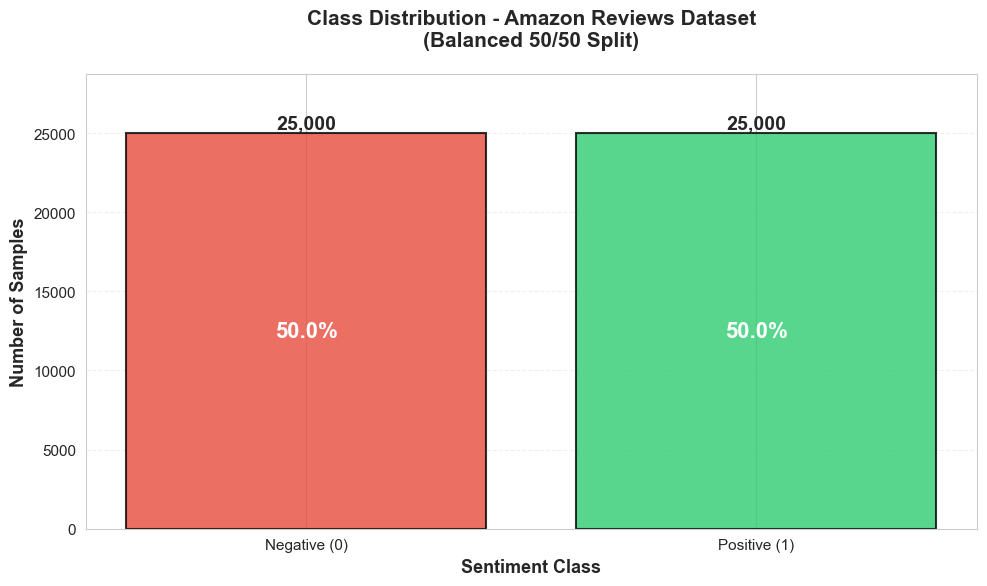


Dataset is balanced: 25000 negative + 25000 positive = 50000 total samples


In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

class_counts = df['label'].value_counts().sort_index()
labels = ['Negative (0)', 'Positive (1)']
counts = [class_counts[0], class_counts[1]]

colors = ['#e74c3c', '#2ecc71'] 
bars = ax.bar(labels, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Number of Samples', fontsize=13, fontweight='bold')
ax.set_xlabel('Sentiment Class', fontsize=13, fontweight='bold')
ax.set_title('Class Distribution - Amazon Reviews Dataset\n(Balanced 50/50 Split)', 
            fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(counts) * 1.15)

total = sum(counts)
for i, (label, count) in enumerate(zip(labels, counts)):
    percentage = (count / total) * 100
    ax.text(i, count * 0.5, f'{percentage:.1f}%', 
            ha='center', va='center', fontsize=16, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

print(f"\nDataset is balanced: {counts[0]} negative + {counts[1]} positive = {total} total samples")

## 5. Analiza Długości Tekstu (Boxplot i Histogram)

Obliczenie liczby słów dla każdej recenzji i porównanie rozkładów między klasami pozytywnymi i negatywnymi.

In [6]:
print("Calculating text statistics...")

df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

def avg_word_length(text):
    words = str(text).split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

df['avg_word_length'] = df['text'].apply(avg_word_length)

negative_df = df[df['label'] == 0]
positive_df = df[df['label'] == 1]

print("\n" + "="*80)
print("QUANTITATIVE TEXT ANALYSIS")
print("="*80)

print("\nNEGATIVE REVIEWS (label=0):")
print("-" * 80)
print(f"{'Metric':<25} {'Mean':<12} {'Std':<12} {'Min':<10} {'Max':<10}")
print("-" * 80)
print(f"{'Word Count':<25} {negative_df['word_count'].mean():<12.2f} {negative_df['word_count'].std():<12.2f} {negative_df['word_count'].min():<10} {negative_df['word_count'].max():<10}")
print(f"{'Character Count':<25} {negative_df['char_count'].mean():<12.2f} {negative_df['char_count'].std():<12.2f} {negative_df['char_count'].min():<10} {negative_df['char_count'].max():<10}")
print(f"{'Avg Word Length':<25} {negative_df['avg_word_length'].mean():<12.2f} {negative_df['avg_word_length'].std():<12.2f} {negative_df['avg_word_length'].min():<10.2f} {negative_df['avg_word_length'].max():<10.2f}")

print("\nPOSITIVE REVIEWS (label=1):")
print("-" * 80)
print(f"{'Metric':<25} {'Mean':<12} {'Std':<12} {'Min':<10} {'Max':<10}")
print("-" * 80)
print(f"{'Word Count':<25} {positive_df['word_count'].mean():<12.2f} {positive_df['word_count'].std():<12.2f} {positive_df['word_count'].min():<10} {positive_df['word_count'].max():<10}")
print(f"{'Character Count':<25} {positive_df['char_count'].mean():<12.2f} {positive_df['char_count'].std():<12.2f} {positive_df['char_count'].min():<10} {positive_df['char_count'].max():<10}")
print(f"{'Avg Word Length':<25} {positive_df['avg_word_length'].mean():<12.2f} {positive_df['avg_word_length'].std():<12.2f} {positive_df['avg_word_length'].min():<10.2f} {positive_df['avg_word_length'].max():<10.2f}")

print("\nLENGTH PERCENTILES (for max_length padding decisions):")
print("-" * 80)
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    val = df['word_count'].quantile(p/100)
    print(f"{p}th percentile: {val:.0f} words ({p}% of reviews are under {val:.0f} words)")

print("\nINSIGHT: Are angry reviews longer than happy ones?")
diff = negative_df['word_count'].mean() - positive_df['word_count'].mean()
if abs(diff) > 5:
    longer = "Negative" if diff > 0 else "Positive"
    print(f"- {longer} reviews are {abs(diff):.1f} words longer on average")
else:
    print(f"- No significant difference (Δ = {diff:.1f} words)")

print("\nCOMPLEXITY: Do negative reviews use more complex words?")
complexity_diff = negative_df['avg_word_length'].mean() - positive_df['avg_word_length'].mean()
if abs(complexity_diff) > 0.1:
    more_complex = "Negative" if complexity_diff > 0 else "Positive"
    print(f"- {more_complex} reviews use {abs(complexity_diff):.2f} character longer words on average")
else:
    print(f"- No significant difference (Δ = {complexity_diff:.2f} chars/word)")

print("="*80)

Calculating text statistics...

QUANTITATIVE TEXT ANALYSIS

NEGATIVE REVIEWS (label=0):
--------------------------------------------------------------------------------
Metric                    Mean         Std          Min        Max       
--------------------------------------------------------------------------------
Word Count                80.26        42.13        13         209       
Character Count           439.83       233.55       100        1014      
Avg Word Length           4.49         0.45         2.87       22.57     

POSITIVE REVIEWS (label=1):
--------------------------------------------------------------------------------
Metric                    Mean         Std          Min        Max       
--------------------------------------------------------------------------------
Word Count                74.92        42.54        11         204       
Character Count           412.52       237.12       100        1014      
Avg Word Length           4.52         0.

Generating Enhanced WordClouds with Sentiment-Specific Styling...


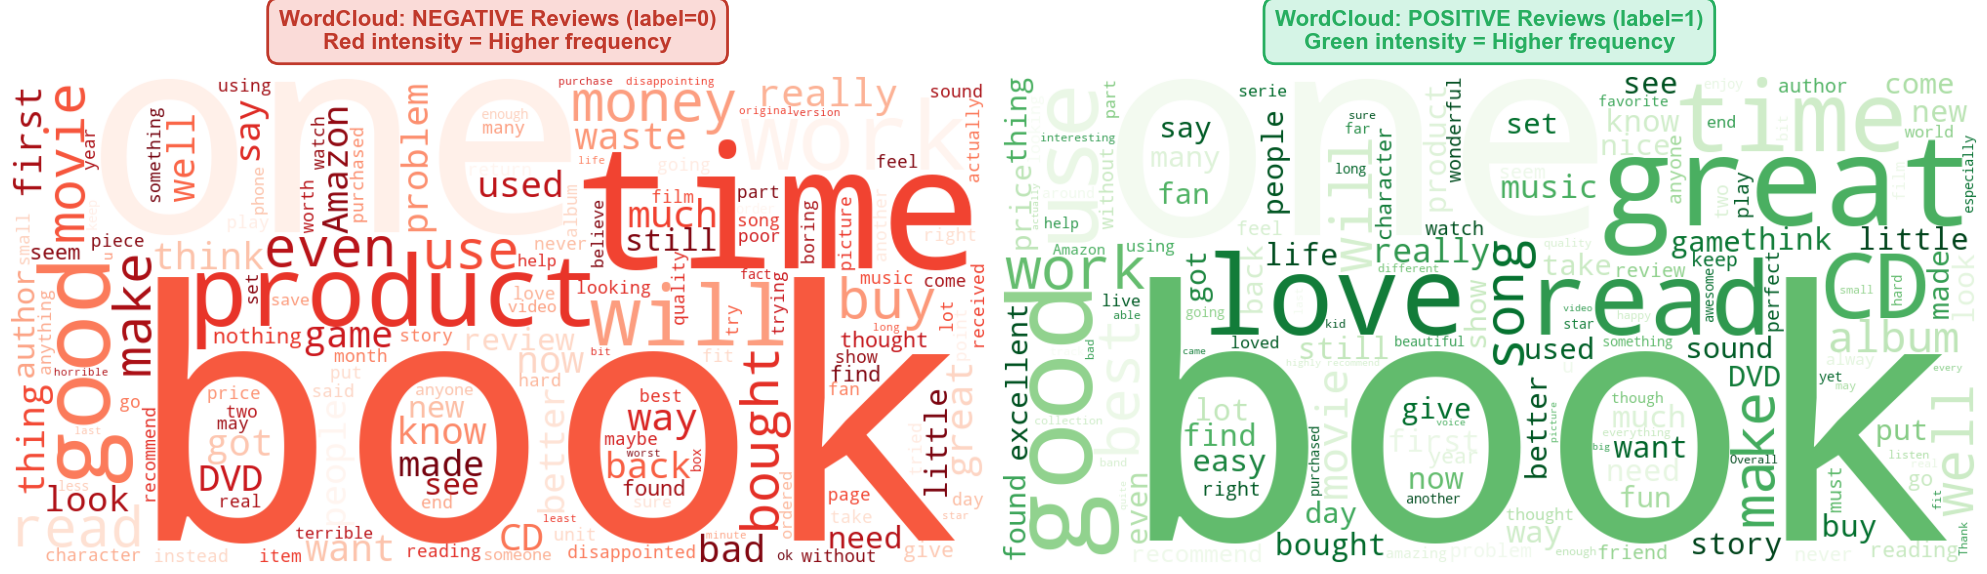


WordClouds generated successfully

KEY INSIGHTS from WordClouds:
   - Words that appear in BOTH clouds are domain-neutral
   - These are domain-specific stopwords and will be removed in Notebook 2
   - Words appearing in only ONE cloud are strong sentiment indicators


In [7]:
negative_text = ' '.join(df[df['label'] == 0]['text'].astype(str))
positive_text = ' '.join(df[df['label'] == 1]['text'].astype(str))

print("Generating Enhanced WordClouds with Sentiment-Specific Styling...")

wordcloud_negative = WordCloud(
    width=1000, 
    height=500,
    background_color='white',
    colormap='Reds',  
    max_words=150,
    relative_scaling=0.5,
    min_font_size=10,
    random_state=RANDOM_SEED,
    collocations=True 
).generate(negative_text)

wordcloud_positive = WordCloud(
    width=1000, 
    height=500,
    background_color='white',
    colormap='Greens',  
    max_words=150,
    relative_scaling=0.5,
    min_font_size=10,
    random_state=RANDOM_SEED,
    collocations=True 
).generate(positive_text)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].imshow(wordcloud_negative, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('WordCloud: NEGATIVE Reviews (label=0)\nRed intensity = Higher frequency', 
                fontsize=16, fontweight='bold', pad=20, 
                color='#c0392b',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#fadbd8', edgecolor='#c0392b', linewidth=2))

axes[1].imshow(wordcloud_positive, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('WordCloud: POSITIVE Reviews (label=1)\nGreen intensity = Higher frequency', 
                fontsize=16, fontweight='bold', pad=20, 
                color='#27ae60',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#d5f4e6', edgecolor='#27ae60', linewidth=2))

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("WordClouds generated successfully")
print("="*80)
print("\nKEY INSIGHTS from WordClouds:")
print("   - Words that appear in BOTH clouds are domain-neutral")
print("   - These are domain-specific stopwords and will be removed in Notebook 2")
print("   - Words appearing in only ONE cloud are strong sentiment indicators")
print("="*80)

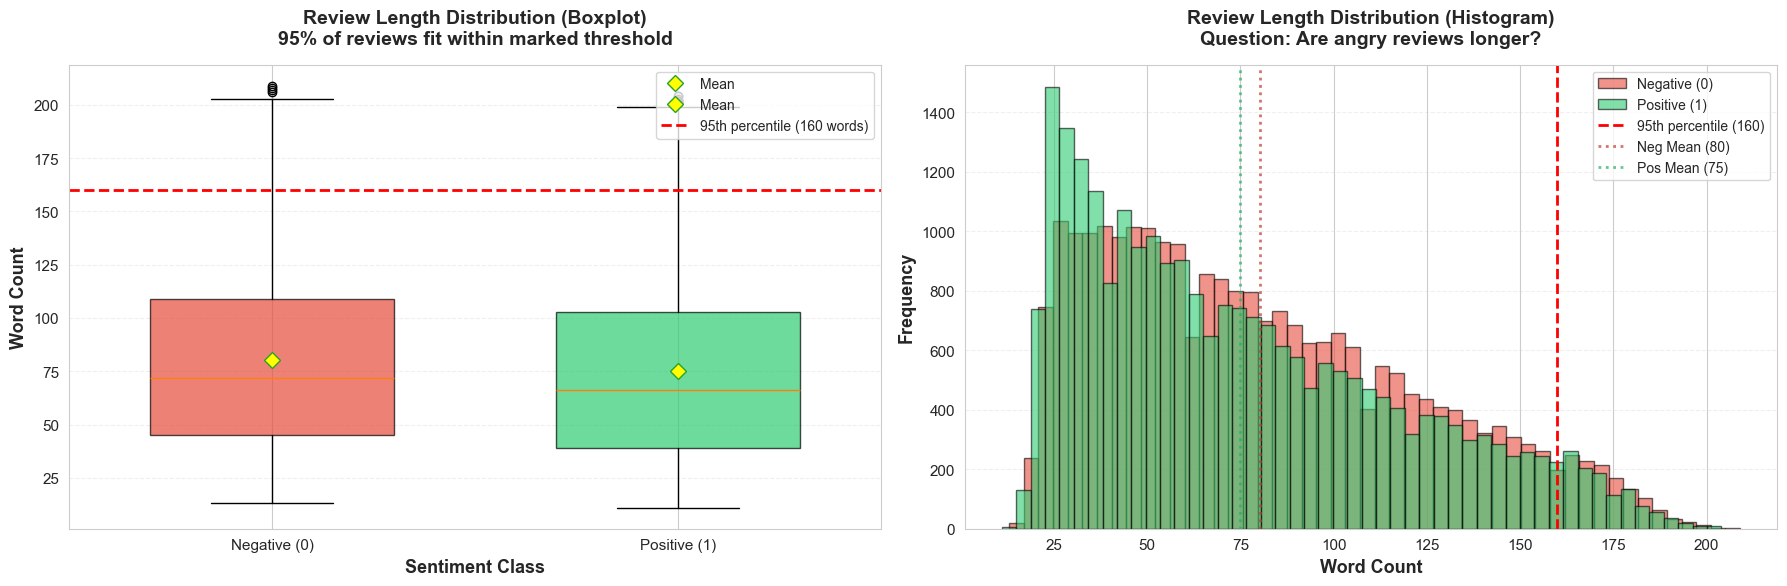


Text length analysis complete
Negative reviews: μ=80.3 words, σ=42.1
Positive reviews: μ=74.9 words, σ=42.5
95th percentile: 160 words (recommended max_length for padding)


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

negative_lengths = df[df['label'] == 0]['word_count']
positive_lengths = df[df['label'] == 1]['word_count']

percentile_95 = df['word_count'].quantile(0.95)

ax1 = axes[0]
box_data = [negative_lengths, positive_lengths]
bp = ax1.boxplot(box_data, 
                labels=['Negative (0)', 'Positive (1)'],
                patch_artist=True,
                widths=0.6,
                showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='yellow', markersize=8, label='Mean'))

colors = ['#e74c3c', '#2ecc71']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.axhline(y=percentile_95, color='red', linestyle='--', linewidth=2, 
            label=f'95th percentile ({percentile_95:.0f} words)')

ax1.set_ylabel('Word Count', fontsize=13, fontweight='bold')
ax1.set_xlabel('Sentiment Class', fontsize=13, fontweight='bold')
ax1.set_title('Review Length Distribution (Boxplot)\n95% of reviews fit within marked threshold', 
              fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

ax2 = axes[1]

ax2.hist(negative_lengths, bins=50, alpha=0.6, color='#e74c3c', label='Negative (0)', edgecolor='black')
ax2.hist(positive_lengths, bins=50, alpha=0.6, color='#2ecc71', label='Positive (1)', edgecolor='black')

ax2.axvline(x=percentile_95, color='red', linestyle='--', linewidth=2, 
            label=f'95th percentile ({percentile_95:.0f})')

ax2.axvline(x=negative_lengths.mean(), color='#c0392b', linestyle=':', linewidth=2, 
            alpha=0.7, label=f'Neg Mean ({negative_lengths.mean():.0f})')
ax2.axvline(x=positive_lengths.mean(), color='#27ae60', linestyle=':', linewidth=2, 
            alpha=0.7, label=f'Pos Mean ({positive_lengths.mean():.0f})')

ax2.set_xlabel('Word Count', fontsize=13, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=13, fontweight='bold')
ax2.set_title('Review Length Distribution (Histogram)\nQuestion: Are angry reviews longer?', 
            fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=10, loc='upper right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nText length analysis complete")
print(f"Negative reviews: μ={negative_lengths.mean():.1f} words, σ={negative_lengths.std():.1f}")
print(f"Positive reviews: μ={positive_lengths.mean():.1f} words, σ={positive_lengths.std():.1f}")
print(f"95th percentile: {percentile_95:.0f} words (recommended max_length for padding)")

In [9]:
output_dir = 'data/processed'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, 'amazon_subset.csv')

df_to_save = df[['text', 'label']].copy()
df_to_save.to_csv(output_path, index=False, encoding='utf-8')

print(f"\n{'='*80}")
print(f"DATASET SAVED SUCCESSFULLY!")
print(f"{'='*80}")
print(f"Output path:     {output_path}")
print(f"Total samples:   {len(df_to_save):,}")
print(f"  - Negative:   {len(df_to_save[df_to_save['label']==0]):,}")
print(f"  - Positive:   {len(df_to_save[df_to_save['label']==1]):,}")
print(f"Columns:         {list(df_to_save.columns)}")
print(f"File size:       {os.path.getsize(output_path) / (1024*1024):.2f} MB")
print(f"{'='*80}")

print("\nVerifying saved file...")
df_verify = pd.read_csv(output_path)
print(f"File loaded successfully: {len(df_verify):,} rows, {len(df_verify.columns)} columns")
print(f"Label distribution: {dict(df_verify['label'].value_counts().sort_index())}")

print(f"\nFinal Quality Metrics:")
print(f"  - No null values:      {'Yes' if df_verify.isnull().sum().sum() == 0 else 'No'}")
print(f"  - No duplicates:       {'Yes' if df_verify.duplicated(subset=['text']).sum() == 0 else 'No'}")
print(f"  - Balanced classes:    {'Yes' if abs(df_verify['label'].value_counts()[0] - df_verify['label'].value_counts()[1]) < 100 else 'No'}")
print(f"  - Text format:         RAW (not preprocessed)")

print(f"\n{'='*80}")
print("EDA COMPLETE!")
print(f"{'='*80}")
print("\nSUMMARY:")
print("   1. Loaded 50,000 balanced reviews (shuffled sampling)")
print("   2. Performed data quality assurance (null/duplicate/whitespace checks)")
print("   3. Analyzed text statistics (length, complexity)")
print("   4. Conducted N-gram analysis (unigrams, bigrams, trigrams)")
print("   5. Generated polarity-specific visualizations")
print("   6. Saved RAW dataset for downstream processing")
print(f"{'='*80}")


DATASET SAVED SUCCESSFULLY!
Output path:     data/processed\amazon_subset.csv
Total samples:   50,000
  - Negative:   25,000
  - Positive:   25,000
Columns:         ['text', 'label']
File size:       20.62 MB

Verifying saved file...
File loaded successfully: 50,000 rows, 2 columns
Label distribution: {0: np.int64(25000), 1: np.int64(25000)}

Final Quality Metrics:
  - No null values:      Yes
  - No duplicates:       Yes
  - Balanced classes:    Yes
  - Text format:         RAW (not preprocessed)

EDA COMPLETE!

SUMMARY:
   1. Loaded 50,000 balanced reviews (shuffled sampling)
   2. Performed data quality assurance (null/duplicate/whitespace checks)
   3. Analyzed text statistics (length, complexity)
   4. Conducted N-gram analysis (unigrams, bigrams, trigrams)
   5. Generated polarity-specific visualizations
   6. Saved RAW dataset for downstream processing


In [10]:
print("="*80)
print("N-GRAM ANALYSIS (Contextual Patterns)")
print("="*80)

def get_top_ngrams(corpus, n=1, top_k=20):
    vectorizer = CountVectorizer(
        ngram_range=(n, n),
        max_features=top_k,
        stop_words='english',
        token_pattern=r'\b[a-zA-Z]{2,}\b'  
    )
    
    X = vectorizer.fit_transform(corpus)
    ngrams = vectorizer.get_feature_names_out()
    counts = X.sum(axis=0).A1
    
    ngram_freq = sorted(zip(ngrams, counts), key=lambda x: x[1], reverse=True)
    return ngram_freq

negative_corpus = df[df['label'] == 0]['text'].tolist()
positive_corpus = df[df['label'] == 1]['text'].tolist()

print("\n1. TOP 20 UNIGRAMS (Single Words)")
print("-" * 80)

print("\nNEGATIVE Reviews:")
neg_unigrams = get_top_ngrams(negative_corpus, n=1, top_k=20)
for i, (word, count) in enumerate(neg_unigrams, 1):
    print(f"  {i:2d}. {word:<20} ({count:>6,} occurrences)")

print("\nPOSITIVE Reviews:")
pos_unigrams = get_top_ngrams(positive_corpus, n=1, top_k=20)
for i, (word, count) in enumerate(pos_unigrams, 1):
    print(f"  {i:2d}. {word:<20} ({count:>6,} occurrences)")

print("\n" + "="*80)
print("2. TOP 20 BIGRAMS (2-Word Phrases)")
print("="*80)

print("\nNEGATIVE Reviews:")
neg_bigrams = get_top_ngrams(negative_corpus, n=2, top_k=20)
for i, (phrase, count) in enumerate(neg_bigrams, 1):
    print(f"  {i:2d}. {phrase:<30} ({count:>6,} occurrences)")

print("\nPOSITIVE Reviews:")
pos_bigrams = get_top_ngrams(positive_corpus, n=2, top_k=20)
for i, (phrase, count) in enumerate(pos_bigrams, 1):
    print(f"  {i:2d}. {phrase:<30} ({count:>6,} occurrences)")

print("\n" + "="*80)
print("3. TOP 20 TRIGRAMS (3-Word Phrases)")
print("="*80)

print("\nNEGATIVE Reviews:")
neg_trigrams = get_top_ngrams(negative_corpus, n=3, top_k=20)
for i, (phrase, count) in enumerate(neg_trigrams, 1):
    print(f"  {i:2d}. {phrase:<40} ({count:>6,} occurrences)")

print("\nPOSITIVE Reviews:")
pos_trigrams = get_top_ngrams(positive_corpus, n=3, top_k=20)
for i, (phrase, count) in enumerate(pos_trigrams, 1):
    print(f"  {i:2d}. {phrase:<40} ({count:>6,} occurrences)")

print("\n" + "="*80)
print("N-GRAM ANALYSIS COMPLETE")
print("="*80)
print("\nKEY INSIGHTS:")
print("   - Look for phrases that clearly distinguish sentiment")
print("   - Bigrams like 'not good' are stronger than unigram 'good'")
print("   - These patterns will be captured by TF-IDF n-grams in Notebook 2")

N-GRAM ANALYSIS (Contextual Patterns)

1. TOP 20 UNIGRAMS (Single Words)
--------------------------------------------------------------------------------

NEGATIVE Reviews:
   1. book                 (12,558 occurrences)
   2. just                 ( 7,306 occurrences)
   3. like                 ( 7,071 occurrences)
   4. good                 ( 5,802 occurrences)
   5. don                  ( 5,524 occurrences)
   6. time                 ( 4,909 occurrences)
   7. product              ( 4,386 occurrences)
   8. buy                  ( 4,076 occurrences)
   9. money                ( 3,968 occurrences)
  10. work                 ( 3,727 occurrences)
  11. really               ( 3,705 occurrences)
  12. read                 ( 3,466 occurrences)
  13. great                ( 3,291 occurrences)
  14. better               ( 3,254 occurrences)
  15. use                  ( 3,234 occurrences)
  16. bought               ( 3,214 occurrences)
  17. did                  ( 3,179 occurrences)
  18. bad  

### 5.6 Wizualizacje N-Gramów (Wykresy słupkowe)

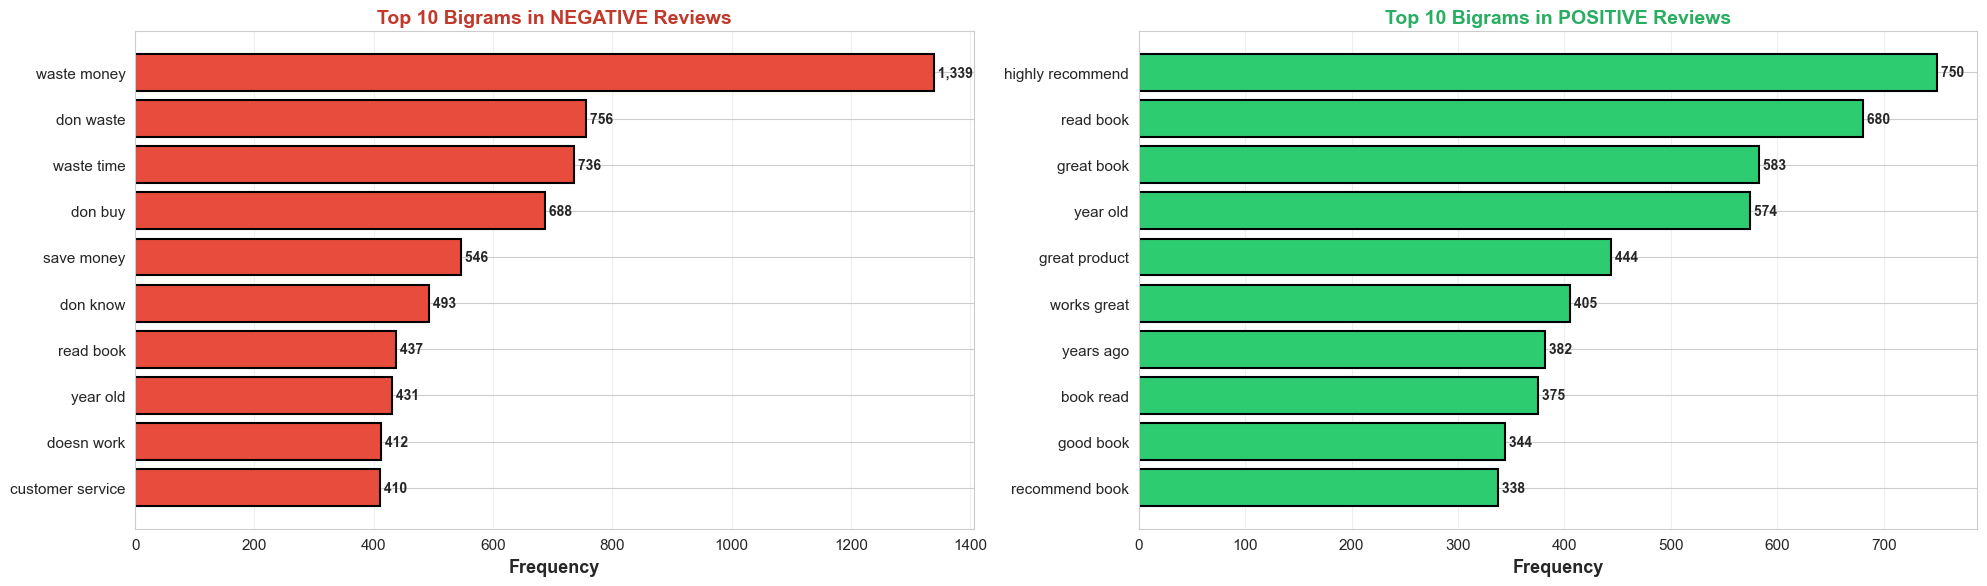

Bigram visualizations complete
These 2-word phrases are much stronger sentiment indicators than single words!


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axes[0]
neg_bigrams_top10 = neg_bigrams[:10]
words = [bg[0] for bg in neg_bigrams_top10]
counts = [bg[1] for bg in neg_bigrams_top10]

bars1 = ax1.barh(words, counts, color='#e74c3c', edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Frequency', fontsize=13, fontweight='bold')
ax1.set_title('Top 10 Bigrams in NEGATIVE Reviews', 
            fontsize=14, fontweight='bold', color='#c0392b')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
            f' {int(width):,}', 
            ha='left', va='center', fontsize=10, fontweight='bold')

ax2 = axes[1]
pos_bigrams_top10 = pos_bigrams[:10]
words = [bg[0] for bg in pos_bigrams_top10]
counts = [bg[1] for bg in pos_bigrams_top10]

bars2 = ax2.barh(words, counts, color='#2ecc71', edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Frequency', fontsize=13, fontweight='bold')
ax2.set_title('Top 10 Bigrams in POSITIVE Reviews', 
            fontsize=14, fontweight='bold', color='#27ae60')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, 
            f' {int(width):,}', 
            ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("Bigram visualizations complete")
print("These 2-word phrases are much stronger sentiment indicators than single words!")